In [14]:
%load_ext autoreload
%autoreload 2

import util as yu
from util import *
import util_moments as yum

yu.setpath('check_2st_vs_sum')

projs=['P0', 'Px', 'Py', 'Pz']
inserts=['tt', 'tx', 'ty', 'tz', 'xx', 'xy', 'xz', 'yy', 'yz', 'zz']
enss=['b','c','d']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path=f'pkl/analysis_c2pt/reg_ignore/ens2pars_jk_meffnst_selected.pkl'
[ens2pars_jk_meff1st,ens2pars_jk_meff2st,ens2pars_jk_meff3st]=yu.load_pkl(path)

In [3]:
key2tf2ratio={}
for ens in enss:
    key2tf2ratio[(ens,'j+;conn')]={}
    key2tf2ratio[(ens,'j-;conn')]={}
    
    basepath=f'/p/project1/ngff/li47/code/projectData/05_moments/{yu.ens2full[ens]}/data_merge/'
    
    mN_jk=ens2pars_jk_meff2st[ens][:,0]
    factor_equal=1/(-3*mN_jk/4)
    
    path=f'{basepath}/conn_2pt.h5'
    with h5py.File(path) as f:
        moms=yu.moms2list(f['moms'])
        imom=moms.index([0,0,0])
        
        tf2c2pt={}
        for tf in f['data'].keys():
            t=f[f'data/{tf}'][:]
            t=yu.jackknife(np.real(t[:,:,imom]))
            tf2c2pt[int(tf)]=t

    path=f'{basepath}/conn_0,0,0,0,0,0.h5'
    with h5py.File(path) as f:
        moms=yu.moms2list(f['moms'])
        imom=moms.index([0,0,0,0,0,0])
        
        for jtf in f['data'].keys():
            j,tf=jtf.split('_'); tf=int(tf)
            t=f[f'data/{jtf}'][:]
            t=t[:,:,0,projs.index('P0'),inserts.index('tt')]
            c3pt=yu.jackknife(t)
            ratio=np.real(c3pt/tf2c2pt[tf][:,tf:tf+1]*factor_equal[:,None])
            key=(ens,j)
            key2tf2ratio[key][tf]=ratio
            
ens2tfs_conn={}
for ens in enss:
    tfs=list(key2tf2ratio[(ens,'j+;conn')].keys()); tfs.sort()
    ens2tfs_conn[ens]=tfs
    print(ens,tfs)

b [8, 10, 12, 14, 16, 18, 20]
c [6, 8, 10, 12, 14, 16, 18, 20, 22]
d [8, 10, 12, 14, 16, 18, 20, 22, 24, 26]


b 8 2
c 10 2
d 12 2


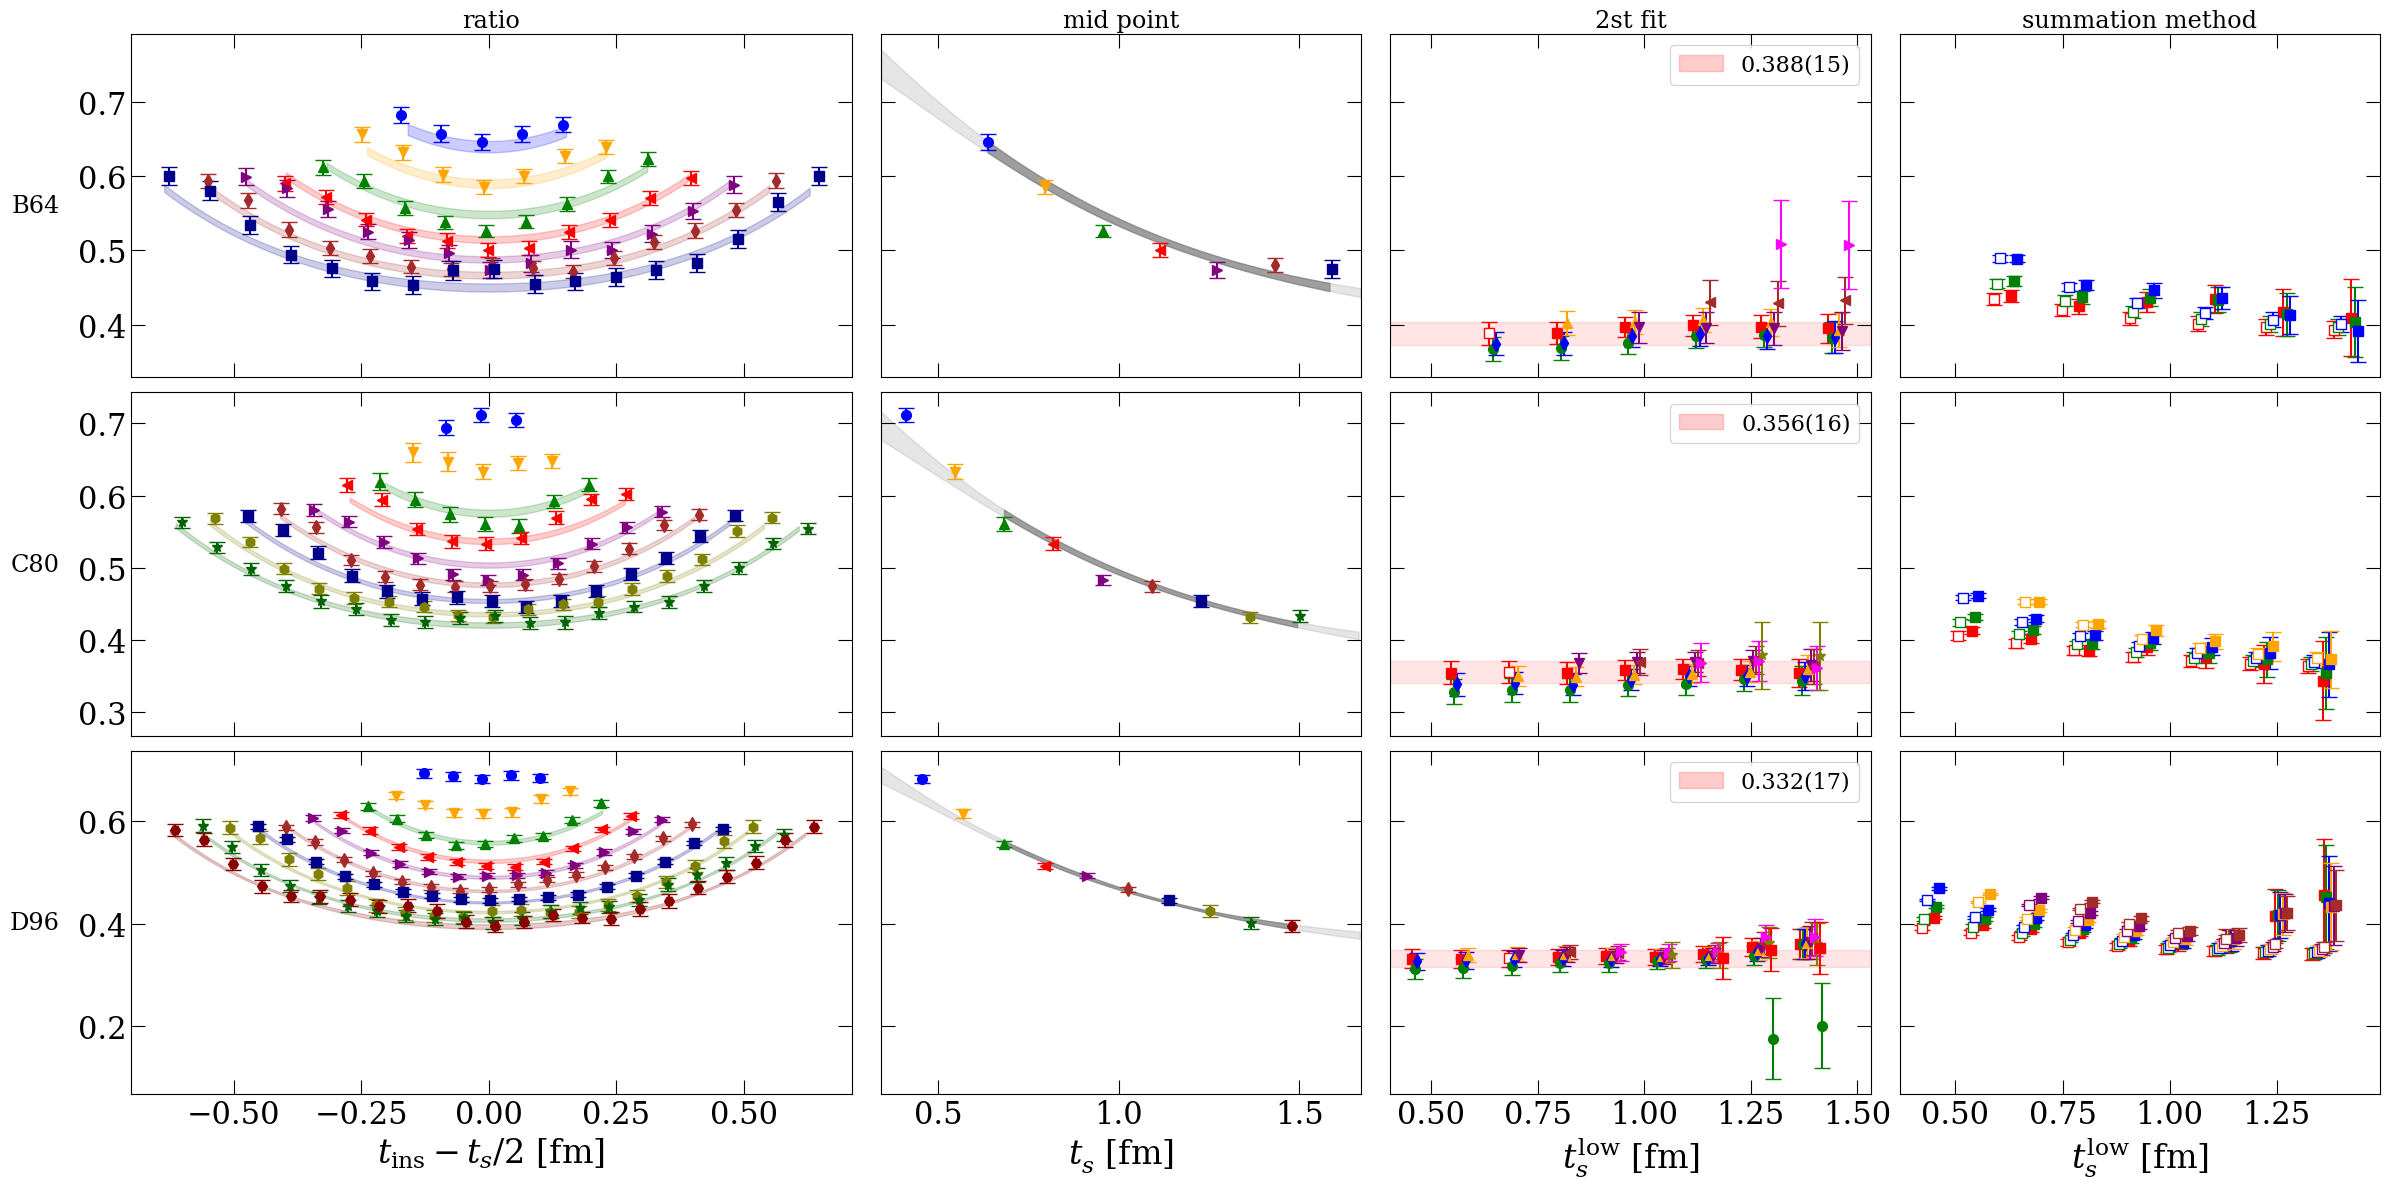

In [85]:
key2bare={}

overwrite=False
def createDic(key):
    ens,j=key
    gett=lambda t:round(t/yu.ens2a[ens])
    gett2=lambda t:round(t/yu.ens2a[ens]/2)*2
    def get_tfs(tmin,tmax,dt=1):
        return range(gett(tmin),gett(tmax),dt)
    lat_a=yu.ens2a[ens]
    
    # tfmins_1st=get_tfs(0.5,1.2)
    # tcmins_1st=get_tfs(2*lat_a,0.5)
    # tfmins_2st=get_tfs(0.5,0.8)
    # tcmins_2st=get_tfs(2*lat_a,0.3)
    
    tfmins_2st=range(8,ens2tfs_conn[ens][-1],2); tcmins_2st=range(2,ens2tfs_conn[ens][-1]//2-1)
    
    pars_jk_meff2st=ens2pars_jk_meff2st[ens]
    fittype='2st2step_SYMshare'
    
    tf2ratio=key2tf2ratio[(ens,j)]
    fits_sum=yu.doFits_3pt('sum',tf2ratio,tfmins_2st,tcmins_2st,label=f'{ens}_{j}_sum',overwrite=False)
    fits_2st=yu.doFits_3pt(fittype,tf2ratio,tfmins_2st,tcmins_2st,pars_jk_meff2st=pars_jk_meff2st,symmetrizeQ=True,label=f'{ens}_{j}_2st',overwrite=overwrite)
    tfmin=gett2(0.7); tcmin=gett(0.12)
    tfmin=gett2(8*yu.ens2a['b']); tcmin=2
    print(ens,tfmin,tcmin)
    fit_2st_MA=yu.doMA_3pt(fits_2st,fitlabels=(tfmin,tcmin))
    
    # print('\n'.join(yu.fits2text(fit_2st_MA[-1])))
    
    dic={
        'base:[tf2ratio,fits_band,fits_const,fits_sum,fits_2st]':[tf2ratio,None,None,None,fits_2st],
        'WAMA:[fit_band_WA,fit_const_MA,fit_sum_MA,fit_2st_MA]':[None,None,None,fit_2st_MA],
        'rainbow:[tfmin,tfmax,tcmin,dt]':[None,None,2,None],
        'fit_sum:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,2,5],
        'fit_2st:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,2,5],
        'fit_2st_rainbow_midpoint:[fittype,pars_jk_meff2st]':[fittype,ens2pars_jk_meff2st[ens]],
        'xunit':yu.ens2a[ens],
    }
    return dic

js_plt=['j+;conn']; enss_plt=['b','c','d'][:]

for ij,j in enumerate(js_plt):
    # print(f'{ij}/{len(js_plt)}',j,end='                 \r')
    keys=[(ens,j) for ens in enss_plt]

    list_dic=[createDic(key) for key in keys]

    fig,axs=yu.makePlot_3pt(list_dic,shows=['rainbow','midpoint','fit_2st','fit_sum'])
    
    for i in range(len(list_dic)):
        ens=enss_plt[i]
        dic=list_dic[i]
        fit=dic['WAMA:[fit_band_WA,fit_const_MA,fit_sum_MA,fit_2st_MA]'][-1]
        xunit=yu.ens2a[ens]; yunit=1
        pars_jk,probs_jk,fits=fit
        [(tfmin,tcmin),pars_jk,chi2_jk,Ndof]=fits[0]
        
        pars_jk_meff2st=dic['fit_2st_rainbow_midpoint:[fittype,pars_jk_meff2st]'][-1]
        pars_jk=np.concatenate([pars_jk,pars_jk_meff2st[:,[1,2]]],axis=1)
        tf2ratio={}
        ax=axs[i,0]
        for tf in ens2tfs_conn[ens]:
            tcs=np.arange(0,tf+1,1)
            ratio=np.array([yu.func_ratioSYMshare_2st(tf,tcs,*pars) for pars in pars_jk])
            tf2ratio[tf]=ratio
            
            mean,err=yu.jackme(ratio)
            tmin=2; tmax=tf-1
            plt_x=(tcs[tmin:tmax]-tf/2)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
            # ax.errorbar(plt_x,plt_y,plt_yerr,mfc='white')
        
        ax=axs[i,-1]
        tfmins_2st=range(8,ens2tfs_conn[ens][-1],2); tcmins_2st=range(2,ens2tfs_conn[ens][-1]//2-1)[:-4]
        
        fits_sum=yu.doFits_3pt('sum',key2tf2ratio[(ens,j)],tfmins_2st,tcmins_2st,corrQ=False)
        for [(tfmin,tcmin),pars_jk,chi2_jk,Ndof] in fits_sum:
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin+(tcmin-3)*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,mfc=None,color=yu.colors8[tcmins_2st.index(tcmin)])
            
        fits_sum=yu.doFits_3pt('sum',tf2ratio,tfmins_2st,tcmins_2st,corrQ=False)
        for [(tfmin,tcmin),pars_jk,chi2_jk,Ndof] in fits_sum:
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin+(tcmin-3)*0.1-0.5)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,mfc='white',color=yu.colors8[tcmins_2st.index(tcmin)])
    
    yu.addRowHeader(axs,[yu.ens2label[ens] for ens in enss_plt])
    yu.finalizePlot(j,closeQ=False)